In [0]:
import keras
from keras import models, layers, regularizers, optimizers
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from keras.preprocessing.image import ImageDataGenerator, load_img
import random
from PIL import Image
from sklearn.model_selection import train_test_split

In [0]:
WIDTH = 64
HEIGHT = 64
CHANNELS = 3
IMG_SIZE = (WIDTH, HEIGHT)
batch_size = 16
epochs = 50

In [84]:
print(os.listdir("../content/datasets/"))

['sampleSubmission.csv', 'test1', '.git', 'README.md', 'train']


In [0]:
train_path = "../content/datasets/train/train/"
filenames = os.listdir(train_path)
categories = []
for filename in filenames:
    if filename.split('.')[0] == 'dog':
        categories.append('1')
    else:
        categories.append('0')

In [0]:
test_path = "../content/datasets/test1/test1/"
test_filenames = os.listdir(test_path)
test_categories = []
for filename in test_filenames:
    if filename.split('.')[0] == 'dog':
        test_categories.append('1')
    else:
        test_categories.append('0')

In [87]:
to_categorical(categories)

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [0., 1.]], dtype=float32)

In [0]:
df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [0]:
test_df = pd.DataFrame({
    'filename': test_filenames
})

In [90]:
df.head()

,filename,category
0,dog.1059.jpg,1
1,dog.3777.jpg,1
2,dog.6886.jpg,1
3,cat.6430.jpg,0
4,cat.398.jpg,0


In [91]:
df.tail()

,filename,category
24995,cat.12390.jpg,0
24996,cat.3390.jpg,0
24997,cat.9077.jpg,0
24998,cat.12378.jpg,0
24999,dog.9047.jpg,1


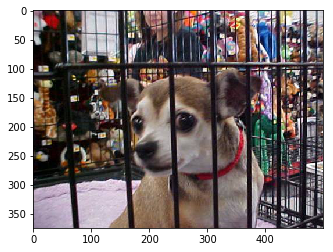

In [92]:
sample = random.choice(filenames)
image = Image.open(train_path+sample)
plt.imshow(image)

In [93]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(WIDTH, HEIGHT, CHANNELS)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.1))

model.add(layers.Conv2D(64, (3, 3)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.1))

model.add(layers.Conv2D(128, (3, 3)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.1))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 62, 62, 32)        896       
_________________________________________________________________
batch_normalization_13 (Batc (None, 62, 62, 32)        128       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 29, 29, 64)        18496     
_________________________________________________________________
batch_normalization_14 (Batc (None, 29, 29, 64)        256       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 14, 14, 64)        0         
__________

In [0]:
train_data, validate_data = train_test_split(df, test_size=0.2, shuffle=True)
train_data = train_data.reset_index(drop=True)

In [95]:
print(train_data.shape, validate_data.shape)

(20000, 2) (5000, 2)


In [96]:
train_datagen = ImageDataGenerator(rotation_range=15, rescale=1./255,
                                  shear_range=0.1, zoom_range=0.2,
                                  horizontal_flip=True,
                                  width_shift_range=0.1, height_shift_range=0.1)

train_generator = train_datagen.flow_from_dataframe(train_data, train_path,
                                                   x_col='filename', y_col='category',
                                                   target_size=IMG_SIZE,
                                                   class_mode="categorical",
                                                   batch_size=batch_size)

Found 20000 images belonging to 2 classes.


In [97]:
validation_datagen = ImageDataGenerator(rotation_range=15, rescale=1./255,
                                       shear_range=0.1, zoom_range=0.2,
                                       horizontal_flip=True,
                                       width_shift_range=0.1, height_shift_range=0.1)
validation_generator = validation_datagen.flow_from_dataframe(validate_data, train_path,
                                                             x_col='filename', y_col='category',
                                                             target_size=IMG_SIZE,
                                                             class_mode="categorical",
                                                             batch_size=batch_size)

Found 5000 images belonging to 2 classes.


In [98]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(test_df, test_path,
                                                             x_col='filename', y_col=None,
                                                             target_size=IMG_SIZE,
                                                             class_mode=None,
                                                             batch_size=batch_size)

Found 12500 images.


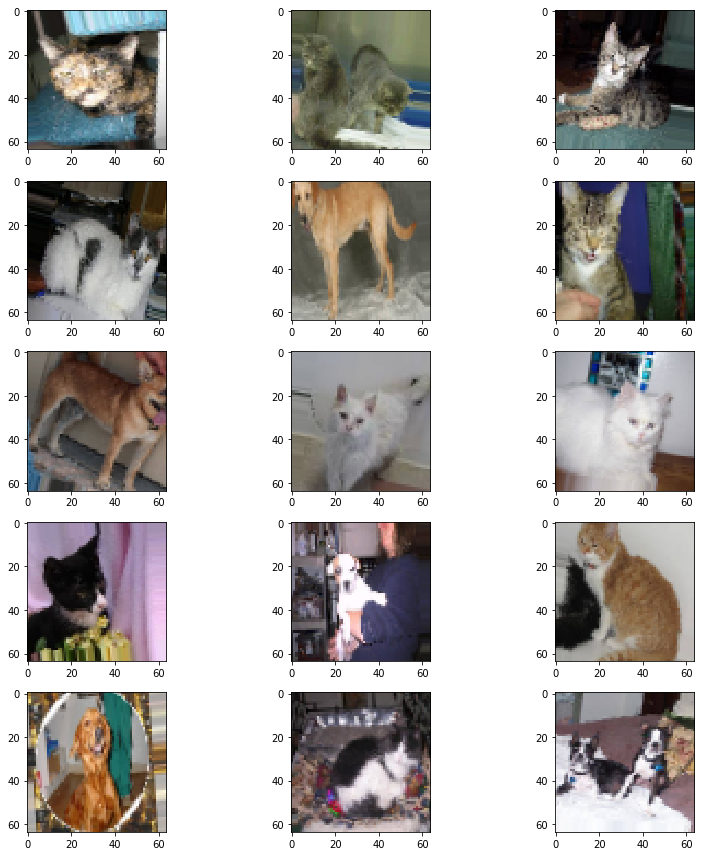

In [99]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in train_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()


In [0]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [0]:
earlystop = EarlyStopping(patience=10)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
callbacks = [earlystop, learning_rate_reduction]


In [102]:
history = model.fit_generator(train_generator, epochs=epochs, steps_per_epoch=train_data.shape[0]//batch_size, 
                    validation_data=validation_generator, validation_steps=validate_data.shape[0]//batch_size, callbacks=callbacks)

Epoch 1/50
1250/1250 [==============================] - 126s 101ms/step - loss: 0.6658 - acc: 0.6147 - val_loss: 0.6639 - val_acc: 0.6512
Epoch 2/50
1250/1250 [==============================] - 123s 98ms/step - loss: 0.5805 - acc: 0.6998 - val_loss: 0.5910 - val_acc: 0.6804
Epoch 3/50
1250/1250 [==============================] - 122s 98ms/step - loss: 0.5426 - acc: 0.7282 - val_loss: 0.5634 - val_acc: 0.7283
Epoch 4/50
1250/1250 [==============================] - 124s 99ms/step - loss: 0.5169 - acc: 0.7481 - val_loss: 0.5465 - val_acc: 0.7123
Epoch 5/50
1250/1250 [==============================] - 122s 98ms/step - loss: 0.5077 - acc: 0.7546 - val_loss: 0.5046 - val_acc: 0.7546
Epoch 6/50
1250/1250 [==============================] - 124s 99ms/step - loss: 0.4858 - acc: 0.7694 - val_loss: 0.5348 - val_acc: 0.7554
Epoch 7/50
1250/1250 [==============================] - 124s 99ms/step - loss: 0.4728 - acc: 0.7784 - val_loss: 0.4635 - val_acc: 0.7887
Epoch 8/50
1250/1250 [==================

In [0]:
model.save_weights("model.h5")

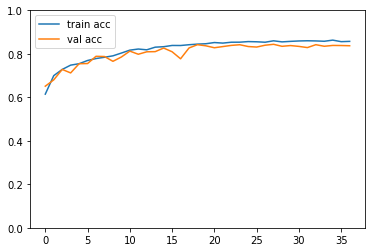

In [104]:
plt.plot(history.history['acc'], label='train acc')
plt.plot(history.history['val_acc'], label='val acc')
plt.legend()
plt.ylim(bottom=0, top=1)
plt.show()

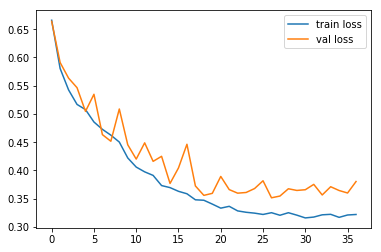

In [105]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

In [0]:
predict = model.predict_generator(test_generator, steps=np.ceil(test_df.shape[0]/batch_size))

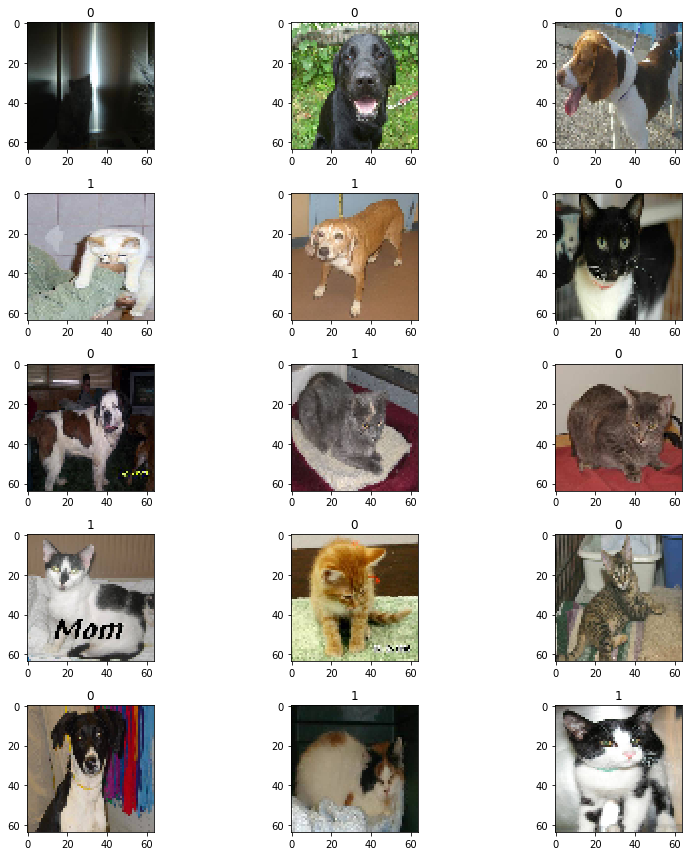

In [107]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch in test_generator:
        image = X_batch[0]
        plt.title(predict[i].argmax())
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()
